# 2. Compute travel times

This notebook computes the travel times from all the points of a three-dimensional grid to each seismic station. These travel times are necessary for time-shifting the seismic traces when evaluating the beamformed network response at every location of the grid.

This tutorial utilizes the `pykonal` package to compute travel times given a velocity model. The package documentation and installation procedure are described in the [pykonal package documentation](https://github.com/malcolmw/pykonal). Please acknowledge [White et al. (2020)](https://pubs.geoscienceworld.org/ssa/srl/article-abstract/91/4/2378/586804/PyKonal-A-Python-Package-for-Solving-the-Eikonal?redirectedFrom=fulltext) if using `pykonal`.

> **Note:** although `pykonal` handles computing the travel times in a three-dimensional velocity model, the example below uses a one-dimensional velocity model.

## Contents

* [Read velocity model](#read-velocity-model)

* [Interpolate velocity model at depth](#interpolate-velocity-model-at-depth)
* [Expand model laterally](#expand-model-laterally)
* [Get station coordinates](#station-coordinates)
* [Show model and stations](#show-model-and-stations)
* [Compute travel times](#compute-travel-times)
* [Save travel times](#save-travel-times)
* [Show travel times at a given station](#show-travel-times-at-a-given-station)

In [35]:
import h5py as h5
import numpy as np
import os
import pandas as pd
import tqdm

from matplotlib import pyplot as plt

from obspy import read, read_inventory
from pykonal.solver import PointSourceSolver
from pykonal.transformations import geo2sph

## Read velocity model

We wrote the velocity model of [Karabulut et al. (2011)](https://www.sciencedirect.com/science/article/pii/S0040195111002903?casa_token=wTzEUe0IdicAAAAA:fYbKmGkHHrQfyLicd0lO4Ai451jT6h_yTF6ZZXrvglpw9rXDTVVzWzIWNQ0aFAFbMJ_pU6I) in a csv file that we read with `pandas`. The model is given in meters for the depth and in m/s for the speed values. Everything is converted to km for compatibility with `pykonal`. 

In [36]:
FILEPATH_VELOCITY = "../data/velocity_model_Karabulut2011.csv"

In [37]:
# Read velocity model
velocity_layers = pd.read_csv(
    FILEPATH_VELOCITY, 
    usecols=[1, 2, 4],
    names=["depth", "P", "S"],
    skiprows=1,
    index_col="depth",
    )

# Convert meters to kilometers
velocity_layers *= 1e-3
velocity_layers.index *= 1e-3

# Show table
velocity_layers.T

depth,-2.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,8.0,10.0,12.0,14.0,15.0,20.0,22.0,25.0,32.0,77.0
P,2.90,3.0,5.60,5.70,5.80,5.90,5.95,6.05,6.10,6.15,6.20,6.25,6.30,6.40,6.50,6.70,8.00,8.045
S,1.67,1.9,3.15,3.21,3.26,3.41,3.42,3.44,3.48,3.56,3.59,3.61,3.63,3.66,3.78,3.85,4.65,4.650


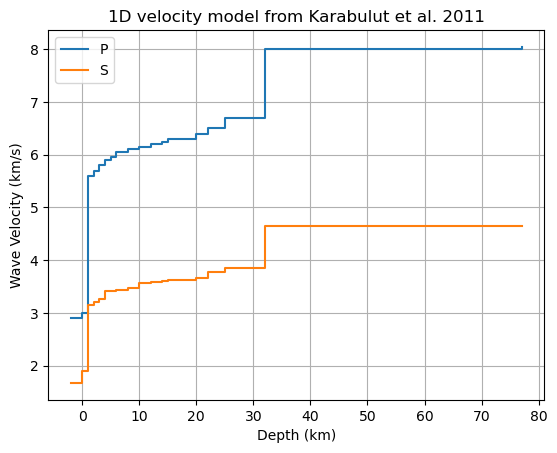

In [38]:
ax = velocity_layers.plot(
    drawstyle="steps-post",
    ylabel="Wave Velocity (km/s)",
    xlabel="Depth (km)",
    title="1D velocity model from Karabulut et al. 2011",
    grid=True,
)

## Interpolate velocity model at depth

We compute the travel times on a finer grid than the model grid, so we need to interpolate the model. We define 30 depths between 30 km and -2 km.

In [39]:
depths = np.linspace(30.0, -2.0, 32)

Then we interpolate the velocity at the given depths using `pandas.DataFrame` method `reindex`.

In [40]:
velocity_layers_interp = velocity_layers.reindex(depths, method="ffill")

We can then compare the natural (layered) and interpolated models as a function of depth

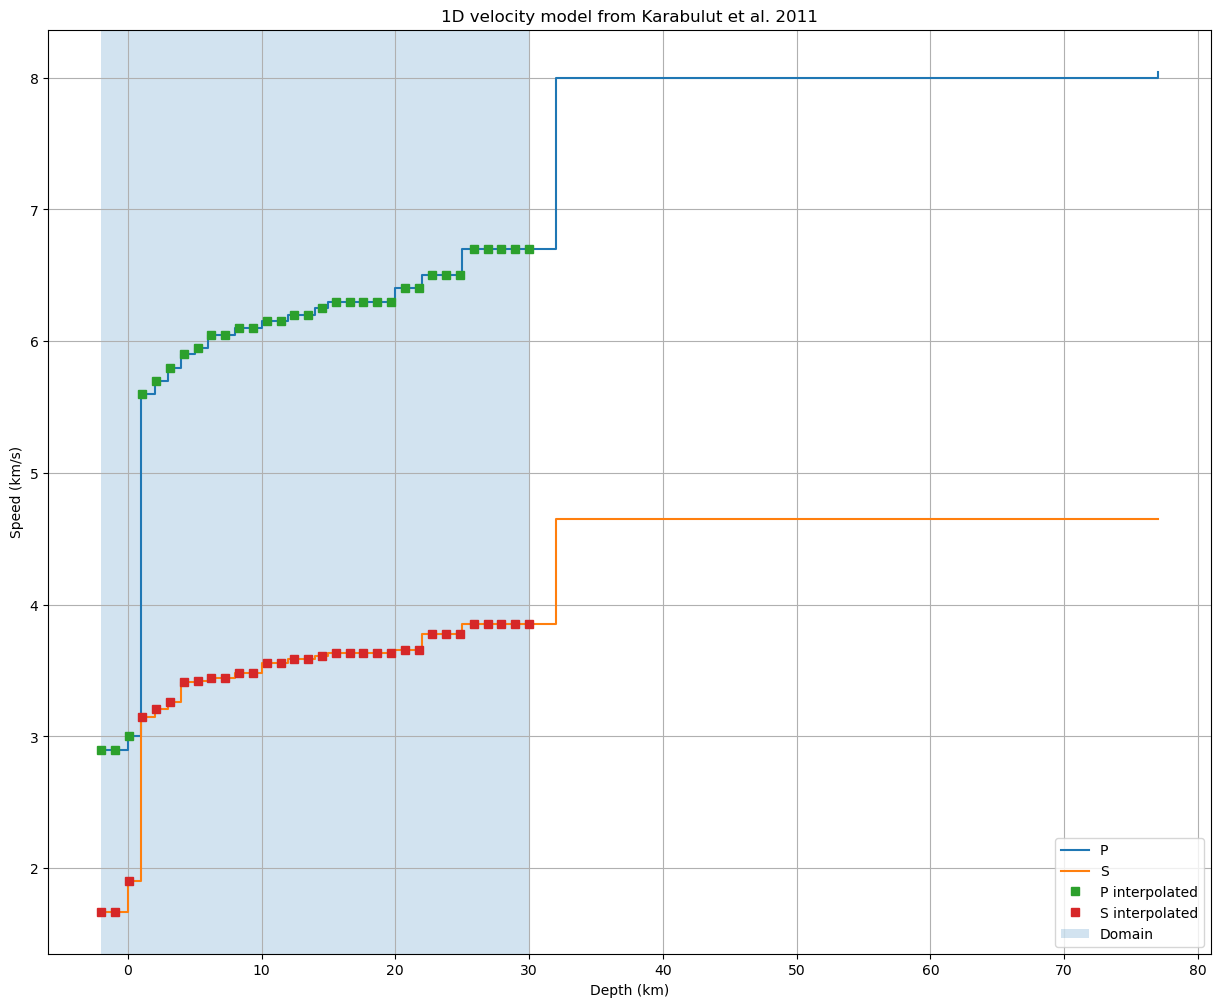

In [41]:
velocity_layers.plot(drawstyle="steps-post")
velocity_layers_interp.sort_values("depth").plot(
    drawstyle="steps-post",
    xlabel="Depth (km)",
    ylabel="Speed (km/s)",
    title="1D velocity model from Karabulut et al. 2011",
    ax=plt.gca(),
    grid=True,
    figsize=(15, 12),
    marker="s",
    ls=""
)

# Labels and legends
plt.axvspan(depths.min(), depths.max(), alpha=0.2)
plt.legend(["P", "S", "P interpolated", "S interpolated", "Domain"])
plt.show()

## Expand model laterally

Because `pykonal` uses three-dimensional coordinate systems, we need to cast the one-dimensional velocity model onto a three-dimensional grid. The following define the grid in the longitude and latitude dimensions.

In [42]:
velocity_layers_interp

,P,S
depth,,
30.000000,6.70,3.85
28.967742,6.70,3.85
27.935484,6.70,3.85
26.903226,6.70,3.85
25.870968,6.70,3.85
24.838710,6.50,3.78
23.806452,6.50,3.78
22.774194,6.50,3.78
21.741935,6.40,3.66


In [43]:
longitudes = np.linspace(30.20, 30.45, 25)
# sample latitudes in decreasing order to get corresponding colatitudes in increasing order (see explanation further)
latitudes = np.linspace(40.76, 40.60, 16)

We then expand the velocity vector in the longitude and latitude dimensions with `xarray`. This operation is automatically done with the `expand_dim()` method.

In [44]:
velocity_P = np.zeros((len(depths), len(latitudes), len(longitudes)), dtype=np.float32)
velocity_S = np.zeros((len(depths), len(latitudes), len(longitudes)), dtype=np.float32)
# use numpy's broadcasting rules
velocity_P[...] = velocity_layers_interp["P"].values[:, None, None]
velocity_S[...] = velocity_layers_interp["S"].values[:, None, None]
# store the P- and S-wave velocity models in a dictionary
velocity_model = {
    "P": velocity_P,
    "S": velocity_S
}

## Station coordinates

We extract the station coordinates from the XML files.

In [45]:
# Get inventories
inventory = read_inventory("../data/processed/*xml")

# Extract stations
stations = [sta for net in inventory for sta in net]
attrs = "longitude", "latitude", "elevation", "code"
stations = [{item: getattr(sta, item) for item in attrs} for sta in stations]

# Turn into dataframe
network = pd.DataFrame(stations).set_index("code")
network["depth"] = -1e-3 * network.elevation 

# Save network metadata
network.to_csv("../data/network.csv")

# Show
network


,longitude,latitude,elevation,depth
code,,,,
DC06,30.265751,40.616718,555.0,-0.555
DC07,30.242170,40.667080,164.0,-0.164
DC08,30.250130,40.744438,162.0,-0.162
DD06,30.317770,40.623539,182.0,-0.182
DE07,30.411539,40.679661,40.0,-0.040
DE08,30.406469,40.748562,31.0,-0.031
SAUV,30.327200,40.740200,170.0,-0.170
SPNC,30.308300,40.686001,190.0,-0.190


## Show model and stations

This cell selects a slice of the velocity model with the `DataArray.sel()` and plots it.

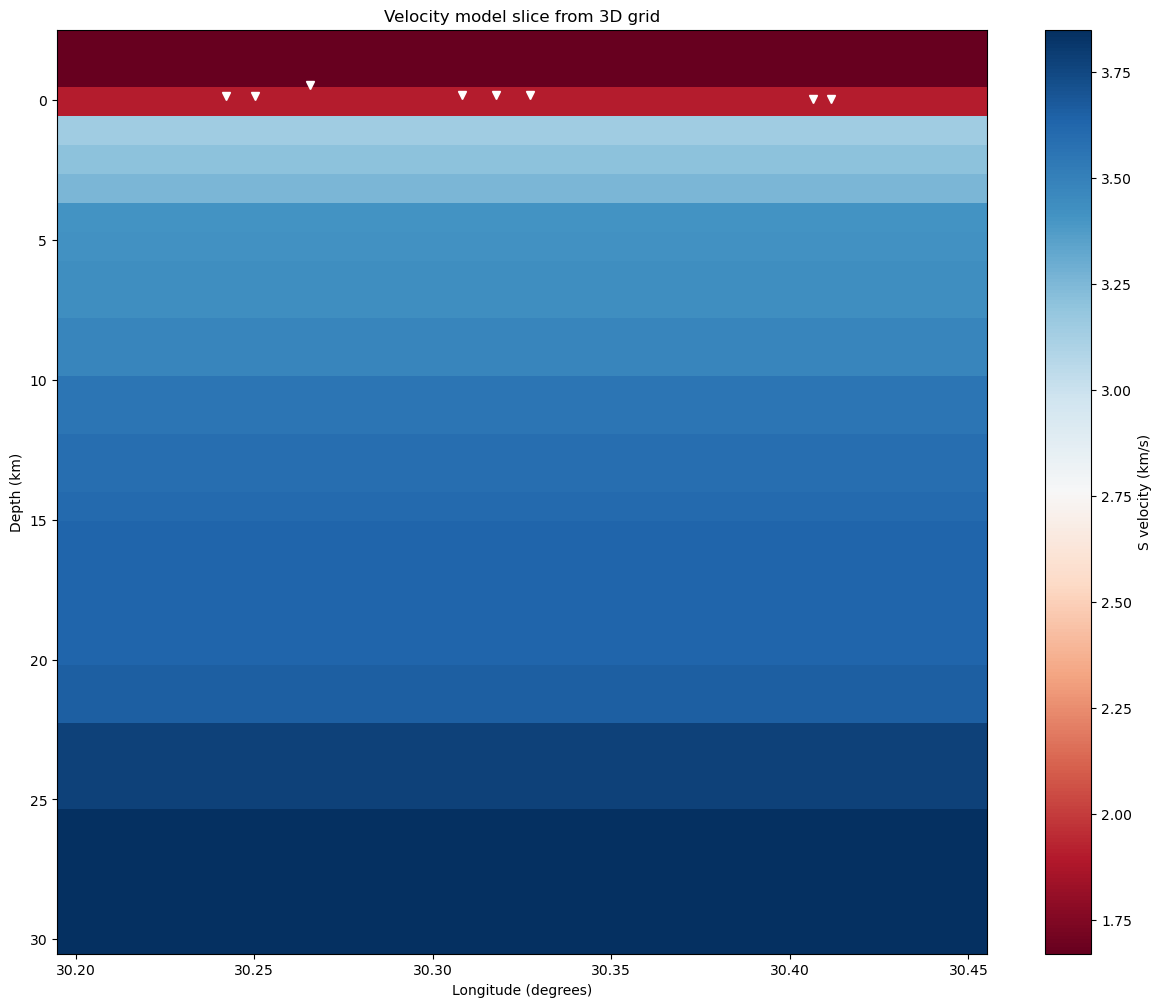

In [46]:
# Select slice at first latitude index
phase = "S"
velocities_slice = velocity_model[phase][:, 0, :]

# Show velocities
fig = plt.figure(figsize=(15, 12))
img = plt.pcolormesh(longitudes, depths, velocities_slice, cmap="RdBu")
cb = plt.colorbar(img)

# Show stations
plt.plot(network.longitude, network.depth, "wv")

# Labels
ax = plt.gca()
ax.set_xlabel("Longitude (degrees)")
ax.set_ylabel("Depth (km)")
ax.set_title("Velocity model slice from 3D grid")
cb.set_label(f"{phase} velocity (km/s)")
ax.invert_yaxis()


## Compute travel times

The travel times are computed for every station with the Eikonal solver of `pykonal`. The travel times are then saved into a `h5` file for later use. 

**Warning**: For `pykonal`, we need to give the velocity grid in spherical coordinates $(r, \theta, \varphi)$, which is why we built the grid with decreasing depths and latitudes.

Spherical coordinates:
- $r$: Distance from center or Earth in km (= decreasing depth).
- $\theta$: Polar angle in radians (= co-latitude or, equivalently, decreasing latitude).
- $\varphi$: Azimuthal angle in radians (= longitude).

In [47]:
STATION_ENTRIES = ["latitude", "longitude", "depth"]

# Initialize travel times
travel_times = {}

# Reference point
reference_point = geo2sph((latitudes.max(), longitudes.min(), depths.max()))
node_intervals = (
    np.abs(depths[1] - depths[0]),
    np.deg2rad(np.abs(latitudes[1] - latitudes[0])),
    np.deg2rad(longitudes[1] - longitudes[0]),
)

# Loop over stations and phases
for phase in velocity_model:
    travel_times[phase] = {}
    for station in tqdm.tqdm(network.index, desc=f"Travel times {phase}"):

        # Initialize Eikonal solver
        solver = PointSourceSolver(coord_sys="spherical")
        solver.velocity.min_coords = reference_point
        solver.velocity.node_intervals = node_intervals
        velocity = velocity_model[phase]
        solver.velocity.npts = velocity.shape
        solver.velocity.values = velocity.copy()
        
        # Source
        src_loc = network.loc[station][STATION_ENTRIES].values
        solver.src_loc = np.array(geo2sph(src_loc).squeeze())

        # Solve Eikonal equation
        solver.solve()

        # Update the travel_times dictionary
        tt = solver.tt.values
        # pykonal might produce a singularity at origin
        tt[np.isinf(tt)] = 0
        travel_times[phase][station] = tt

Travel times P:  50%|█████     | 4/8 [00:01<00:01,  2.79it/s]

Travel times S: 100%|██████████| 8/8 [00:02<00:00,  2.68it/s]


## Save travel times and grid coordinates

Save the travel times as a hdf5 file. This format preserves a self-explanatory data structure and supports compression.

In [48]:
# build 3D gridded coordinates from depths, latitudes and longitudes vectors
# these are the coordinates of the points in the travel time grid
depths_g, latitudes_g, longitudes_g = np.meshgrid(
    depths, latitudes, longitudes, indexing="ij"
)

In [49]:
with h5.File("../data/travel_times.h5", mode="w") as ftt:
    ftt.create_group("source_coordinates")
    ftt["source_coordinates"].create_dataset("depth", data=depths_g)
    ftt["source_coordinates"].create_dataset("latitude", data=latitudes_g)
    ftt["source_coordinates"].create_dataset("longitude", data=longitudes_g)
    for phase in ["P", "S"]:
        ftt.create_group(phase)
        for sta in travel_times[phase]:
            ftt[phase].create_dataset(sta, data=travel_times[phase][sta])

## Show travel times at a given station

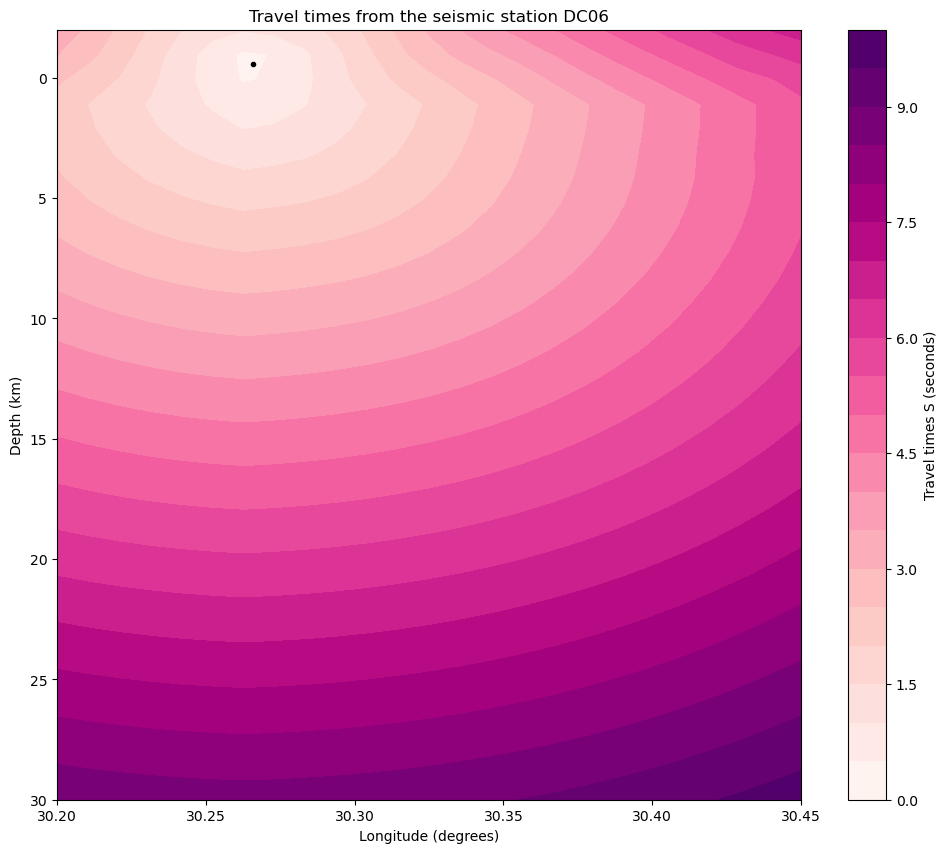

In [50]:
CONTOUR_LEVELS = 20
SEISMIC_PHASE = "S"
station = network.loc["DC06"]

# Show
latitude_id = np.abs(latitudes - station.latitude).argmin()
time_delays = travel_times[SEISMIC_PHASE][station.name]
time_delays = time_delays[:, latitude_id, :]
fig = plt.figure(figsize=(12, 10))
img = plt.contourf(longitudes, depths, time_delays, cmap="RdPu", levels=CONTOUR_LEVELS)

# Colorbar
cb = plt.colorbar(img)
cb.set_label(f"Travel times {SEISMIC_PHASE} (seconds)")

# Station
plt.plot(station.longitude, station.depth, "k.")

# Labels
ax = plt.gca()
ax.invert_yaxis()
ax.set_xlabel("Longitude (degrees)")
ax.set_ylabel("Depth (km)")
ax.set_title(f"Travel times from the seismic station {station.name}")
plt.show()
